<a href="https://colab.research.google.com/github/ParbatiDebbarma/OLA-Ensemble-Learning/blob/main/Business_Case_OLA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Case: OLA** - Ensemble Learning


### **About**

Ola is India’s largest mobility platform and one of the world’s largest ride-hailing companies, serving 250+ cities across India, Australia, New Zealand, and the UK. The Ola app offers mobility solutions by connecting customers to drivers and a wide range of vehicles across bikes, auto-rickshaws, metered taxis, and cabs, enabling convenience and transparency for hundreds of millions of consumers and over 1.5 million driver-partners.

### **Problem Statement**
Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

**Task**: To predict whether a driver will be leaving the company or not based on their attributes like:
* Demographics (city, age, gender etc.)
* Tenure information (joining date, Last Date)
* Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

### **Column Profiling:**
* **MMMM-YY** : Reporting Date (Monthly)
* **Driver_ID** : Unique id for drivers
* **Age** : Age of the driver
* **Gender** : Gender of the driver – Male : 0, Female: 1
* **City** : City Code of the driver
* **Education_Level** : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
* **Income** : Monthly average Income of the driver
* **Date Of Joining** : Joining date for the driver
* **LastWorkingDate** : Last date of working for the driver
* **Joining Designation** : Designation of the driver at the time of joining
* **Grade** : Grade of the driver at the time of reporting
* **Total Business Value** : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
* **Quarterly Rating** : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [ ]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import randint, uniform
from collections import Counter


import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Pandas options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Seaborn Set Style
sns.set_style('ticks')

In [ ]:
# READING THE DATASET FROM CSV FILE

df = pd.read_csv('/content/ola_driver_scaler.csv')
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


## **Exploratory Data Analysis**

In [ ]:
df.duplicated().sum()

0

There are no duplicate records in the dataset

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488


There are Null/NaN Values in the Dataset with 61 in the Age Column, 52 in the Gender Column and 17488 in the LastWorkingDate Column

In [ ]:
# Drop the column.

df = df.drop("Unnamed: 0", axis = 1)

### **Renaming Columns**

In [ ]:
# Renaming the columns:

df.rename(columns={
    'MMM-YY': 'Reporting_Date', # monthly
    'Dateofjoining': 'Date_Of_Joining', # Joining date for the driver
    'LastWorkingDate': 'Last_Working_Date', # Last date of working for the driver
    'Joining Designation': 'Joining_Designation', # Designation of the driver at the time of joining
    'Total Business Value': 'Total_Business_Value', # The total business value acquired by the driver in a month
    'Quarterly Rating': 'Quarterly_Rating' # Quarterly rating of the driver: 1,2,3,4,5 (higher is better)
}, inplace=True)

### **Datatype Conversion for Datetime Columns**

In [ ]:
# Conversion of Date related columns from 'Object' type to 'datetime' data type

df['Reporting_Date'] = pd.to_datetime(df['Reporting_Date'], format='%m/%d/%y')
df['Date_Of_Joining'] = pd.to_datetime(df['Date_Of_Joining'], format="%d/%m/%y")
df['Last_Working_Date'] = pd.to_datetime(df['Last_Working_Date'], format="%d/%m/%y")

### **Inavlid Tenure Records**

In [ ]:
# Identifying rows where 'LastWorkingDate' is before 'Dateofjoining'
invalid_tenure = df[df['Last_Working_Date'] < df['Date_Of_Joining']]

# Print the number of such records
print("Number of records where Last Working Date is before Joining Date:", invalid_tenure.shape[0])

Number of records where Last Working Date is before Joining Date: 135


There are 135 such Inavlid tenure records where the Last Working Date is Before the Joining Date.

###**Quarterly Rating Analysis**

In [ ]:
# Creating Quarterly_Rating_Increased column.

# Sorting by Driver_ID and Reporting_Date to maintain order
df = df.sort_values(by=['Driver_ID', 'Reporting_Date'])

# Creating a column with previous quarter's rating for each driver
df['Prev_Quarterly_Rating'] = df.groupby('Driver_ID')['Quarterly_Rating'].shift(1)

# Creating a new column indicating if the quarterly rating increased
df['Quarterly_Rating_Increased'] = (df['Quarterly_Rating'] > df['Prev_Quarterly_Rating']).astype(int)

# Dropping the helper column if not needed
df.drop(columns=['Prev_Quarterly_Rating'], inplace=True)

# Displaying results
df.head()

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Date_Of_Joining,Last_Working_Date,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating,Quarterly_Rating_Increased
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2,0
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2,0
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-11-03,1,1,0,2,0
3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1,0
4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1,0


###**Monthly Income Analysis**

In [ ]:
# Sorting by Driver_ID and Reporting_Date to maintain order
df = df.sort_values(by=['Driver_ID', 'Reporting_Date'])

# Creating a column with previous month's income for each driver
df['Prev_Income'] = df.groupby('Driver_ID')['Income'].shift(1)

# Creating a new column indicating if the income has increased
df['Income_Increased'] = (df['Income'] > df['Prev_Income']).astype(int)

# Dropping the helper column if not needed
df.drop(columns=['Prev_Income'], inplace=True)


df.head()

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Date_Of_Joining,Last_Working_Date,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating,Quarterly_Rating_Increased,Income_Increased
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2,0,0
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2,0,0
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-11-03,1,1,0,2,0,0
3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1,0,0
4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-06-11,NaT,2,2,0,1,0,0


### **Target Column Creation**

In [ ]:
# Create 'Target' column: 1 if Last_Working_Date is present, 0 otherwise

df['Target'] = df['Last_Working_Date'].notna().astype(int)

### **KNN Imputation**

In [ ]:
from sklearn.impute import KNNImputer

# Selecting only Age and Gender for imputation
knn_cols = ['Age', 'Gender']

# Initialize KNN Imputer with 5 neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN Imputation
df[knn_cols] = knn_imputer.fit_transform(df[knn_cols])

# Round 'Gender' to ensure it's categorical (since KNN gives float values)
df['Gender'] = df['Gender'].round()

In [ ]:
df.isna().sum()

,0
Reporting_Date,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Income,0
Date_Of_Joining,0
Last_Working_Date,17488
Joining_Designation,0


**Aggregating data in order to remove multiple occurrences of same driver data**

In [ ]:
# Storing the aggregated data in 'df'.

df = df.groupby('Driver_ID').agg({
    'Reporting_Date': 'first',   # Keeping the first occurrence (earliest date)
    'Age': 'max',
    'Gender': 'first',
    'City': 'first',
    'Education_Level': 'max',
    'Income': np.mean,
    'Date_Of_Joining': 'first',
    'Last_Working_Date': lambda x: x.dropna().min(), # Get the earliest non-null date
    'Joining_Designation': 'max',
    'Grade': 'max',
    'Total_Business_Value': 'sum',
    'Quarterly_Rating': np.mean,
    'Quarterly_Rating_Increased': 'max',
    'Target': 'max',
    'Income_Increased': 'max'
}).reset_index()

**Checking unique values for Categorical columns**

In [ ]:
df['Gender'].value_counts()

,count
Gender,
0.0,1402
1.0,979


### **Finding Tenure of each driver**

In [ ]:
from datetime import datetime

# Replace 'today' dynamically
today = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))

# Replace missing values in Last_Working_Date with today's date
df['Last_Working_Date'] = pd.to_datetime(df['Last_Working_Date']).fillna(today)
df['Date_Of_Joining'] = pd.to_datetime(df['Date_Of_Joining'])

# Calculate Tenure (difference in years)
df['Tenure'] = (df['Last_Working_Date'] - df['Date_Of_Joining']).dt.days / 365.25

# Drop all the Date columns
df = df.drop(columns=['Date_Of_Joining', 'Last_Working_Date', 'Reporting_Date'])


In [ ]:
df.describe()

,Driver_ID,Age,Gender,Education_Level,Income,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating,Quarterly_Rating_Increased,Target,Income_Increased,Tenure
count,2381.000000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,1397.559009,33.742293,0.411172,1.00756,59232.460484,1.820244,2.097018,4.586742e+06,1.566304,0.345653,0.678706,0.018480,2.544671
std,806.161628,5.917797,0.492150,0.81629,28298.214012,0.841433,0.941702,9.127115e+06,0.719652,0.475681,0.467071,0.134706,2.705605
min,1.000000,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.385530e+06,1.000000,0.000000,0.000000,0.000000,-0.750171
25%,695.000000,30.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.416153
50%,1400.000000,33.000000,0.000000,1.00000,55285.000000,2.000000,2.000000,8.176800e+05,1.000000,0.000000,1.000000,0.000000,1.166324
75%,2100.000000,37.000000,1.000000,2.00000,75835.000000,2.000000,3.000000,4.173650e+06,2.000000,1.000000,1.000000,0.000000,4.484600
max,2788.000000,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,9.533106e+07,4.000000,1.000000,1.000000,1.000000,12.054757


### **Insights Based On The Statistical Summary**

**Age Distribution:** The average age of drivers is 33 years, but there are some extreme values (e.g., 5.83 years, which might be a data issue).

**Income Variability:** The mean income is around 59,232, but there is a high spread, with some drivers earning as low as 10,747 and others up to 188,418.

**Tenure Analysis:** The average tenure seems reasonable, but there are negative tenure values (e.g., -26 months), indicating possible data errors where the last working date is before the joining date.

**Business Value Insights:** Some drivers have negative total business value, possibly due to cancellations or refunds.
The highest-performing drivers generated over 9.5 million in business value.

**Performance Trends:** The quarterly rating mostly stays around 1-2, but some drivers have much higher ratings (up to 4), suggesting variability in performance.
Only ~52% of drivers saw an increase in their quarterly ratings.
~1.8% saw an income increase, which might indicate fewer pay raises or incentives.

In [ ]:
print(f'No. of rows: {df.shape[0]}\nNo. of columns: {df.shape[1]}')

No. of rows: 2381
No. of columns: 14


### **Numerical & Categorical Columns**

In [ ]:
# Filter only numerical columns (int64 and float64)
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
print(f"Numerical Columns: {numerical_columns.columns}")


# Filter only non-numerical columns (object and datetime64[ns])
non_numerical_columns = df.select_dtypes(include=['object', 'datetime64[ns]'])
print(f"Non-Numerical Columns: {non_numerical_columns.columns}")

Numerical Columns: Index(['Driver_ID', 'Age', 'Gender', 'Education_Level', 'Income', 'Joining_Designation', 'Grade', 'Total_Business_Value', 'Quarterly_Rating', 'Quarterly_Rating_Increased', 'Target', 'Income_Increased', 'Tenure'], dtype='object')
Non-Numerical Columns: Index(['City'], dtype='object')


### **Correlation**

In [ ]:
# Checking the correlation between numerical columns.
df.select_dtypes(include=['number']).corr()

,Driver_ID,Age,Gender,Education_Level,Income,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating,Quarterly_Rating_Increased,Target,Income_Increased,Tenure
Driver_ID,1.000000,-0.008520,0.014734,-0.014343,-0.017553,-0.023126,-0.014345,0.015133,0.023867,0.012853,0.029269,-0.018416,0.005573
Age,-0.008520,1.000000,0.034378,-0.007755,0.203767,0.076221,0.248576,0.264488,0.228839,0.180919,-0.078613,0.110444,0.235956
Gender,0.014734,0.034378,1.000000,-0.009832,0.006243,-0.046692,-0.003609,0.016736,-0.001066,0.026214,0.010138,0.024771,0.003430
Education_Level,-0.014343,-0.007755,-0.009832,1.000000,0.140779,0.003203,-0.016806,0.001392,0.037169,0.032223,-0.007953,-0.020377,0.007783
Income,-0.017553,0.203767,0.006243,0.140779,1.000000,0.484116,0.738869,0.368632,0.187621,0.190100,-0.197988,0.062310,0.327671
Joining_Designation,-0.023126,0.076221,-0.046692,0.003203,0.484116,1.000000,0.712419,-0.121368,-0.193807,-0.050452,-0.127773,-0.081889,-0.029268
Grade,-0.014345,0.248576,-0.003609,-0.016806,0.738869,0.712419,1.000000,0.383076,0.109546,0.180237,-0.226190,0.148161,0.353242
Total_Business_Value,0.015133,0.264488,0.016736,0.001392,0.368632,-0.121368,0.383076,1.000000,0.712487,0.521020,-0.379552,0.427368,0.651338
Quarterly_Rating,0.023867,0.228839,-0.001066,0.037169,0.187621,-0.193807,0.109546,0.712487,1.000000,0.655568,-0.373683,0.327552,0.559549
Quarterly_Rating_Increased,0.012853,0.180919,0.026214,0.032223,0.190100,-0.050452,0.180237,0.521020,0.655568,1.000000,-0.371752,0.182234,0.515962


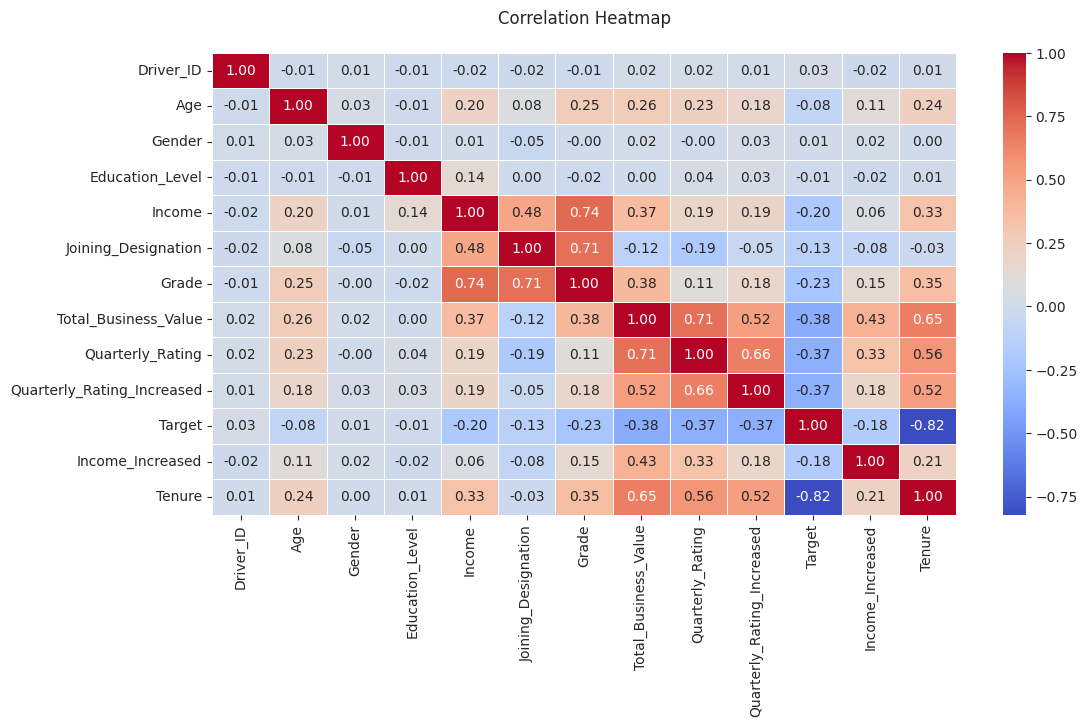

In [ ]:
# Plotting the heatmap for the Correlation matrix.

# Selecting only numeric columns for correlation
corr_matrix = df.select_dtypes(include=['number']).corr()

# Setting up the figure
plt.figure(figsize=(12, 6))

# Creating the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Correlation Heatmap\n")

# Show plot
plt.show()

### **Categorical Features Datatype Conversion**

In [ ]:
# Conversion of features to category.

categorical_columns = [
    'Gender',
    'City',
    'Education_Level',
    'Joining_Designation',
    'Grade',
    'Quarterly_Rating_Increased',
    'Target',
    'Income_Increased'
]

# Converting the columns to categorical
for col in categorical_columns:
    df[col] = df[col].astype('category')

# **Univariate Analysis**

###**Numerical Columns' Analysis**

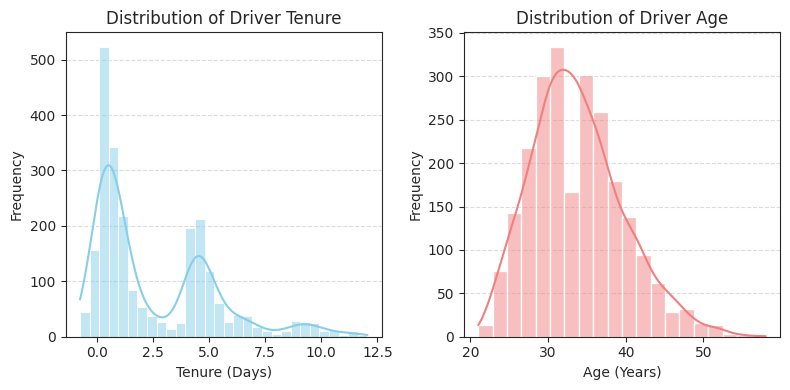

In [ ]:
# Setting figure size
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Tenure Distribution
sns.histplot(df['Tenure'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Driver Tenure')
axes[0].set_xlabel('Tenure (Days)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Age Distribution
sns.histplot(df['Age'], bins=20, kde=True, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution of Driver Age')
axes[1].set_xlabel('Age (Years)')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

**Tenure:**
It has a Right Skewed Distribution
It is observed that there are many drivers with very short tenures.

**Age:**
The driver age range is normally distributed
We see a mix of different age groups with most drivers belonging from the late 20s to late 30s

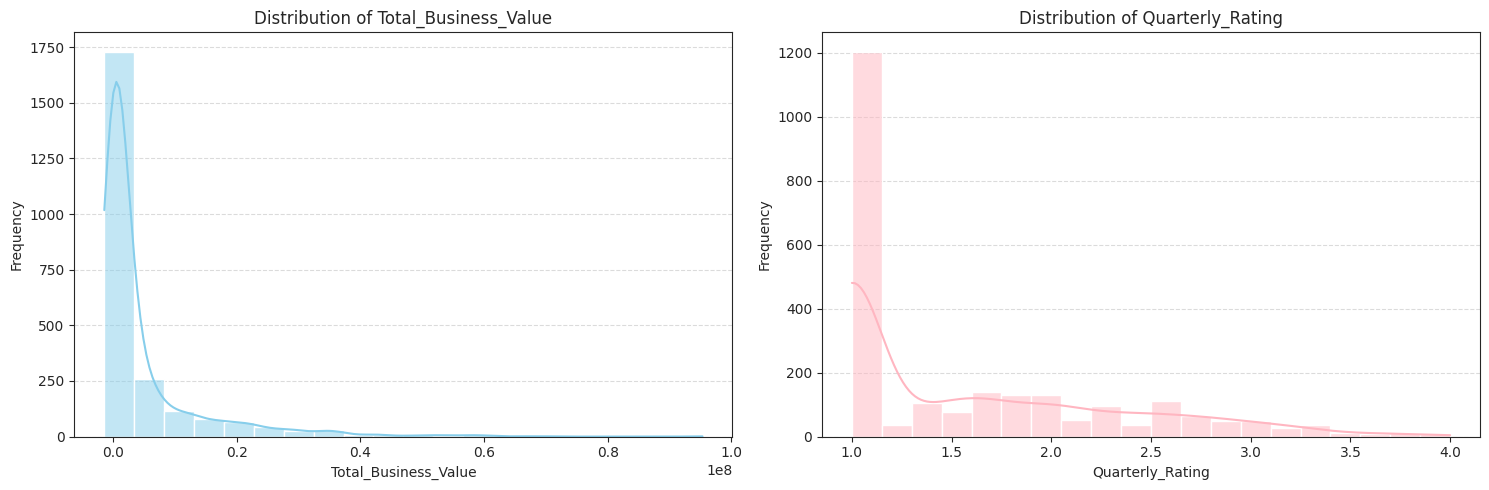

In [ ]:
# Setting figure size
fig, axes = plt.subplots(1,2, figsize=(15, 5))

# Total_Business_Value Distribution
sns.histplot(df['Total_Business_Value'], bins=20, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Total_Business_Value')
axes[0].set_xlabel('Total_Business_Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Quarterly_Rating Distribution
sns.histplot(df['Quarterly_Rating'], bins=20, kde=True, color='lightpink', ax=axes[1])
axes[1].set_title('Distribution of Quarterly_Rating')
axes[1].set_xlabel('Quarterly_Rating')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

**Observations:**

* Total Business Value is highly skewed, with most drivers generating very low business value, while a few contribute significantly higher amounts. This suggests a long-tail distribution, possibly indicating a few high-performing drivers.

* Quarterly Rating is also skewed towards lower values, with most drivers having a rating close to 1. This could imply issues with driver retention, performance, or customer satisfaction.









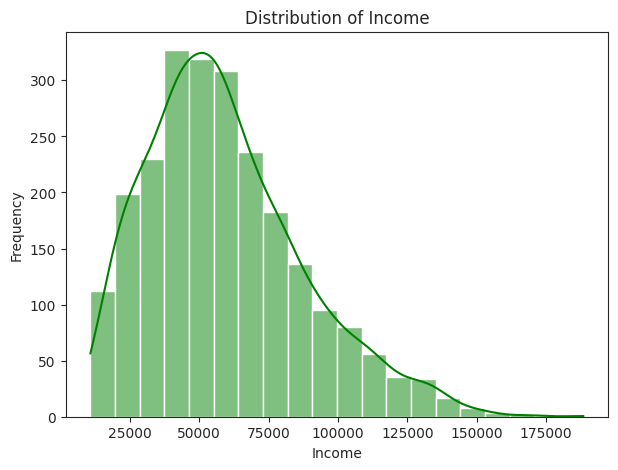

In [ ]:
# Plotting the distribution for 'Income'
plt.figure(figsize=(7, 5))

sns.histplot(df['Income'],
             kde=True,
             bins=20,
             color='green')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

**Inferences from the Distribution of Income:**

* The Income distribution is slightly right-skewed, with most individuals earning in the range of 50,000 to 75,000.

* There are fewer individuals with very high incomes (above 125,000), indicating a concentration of earnings in the lower to mid-income range.

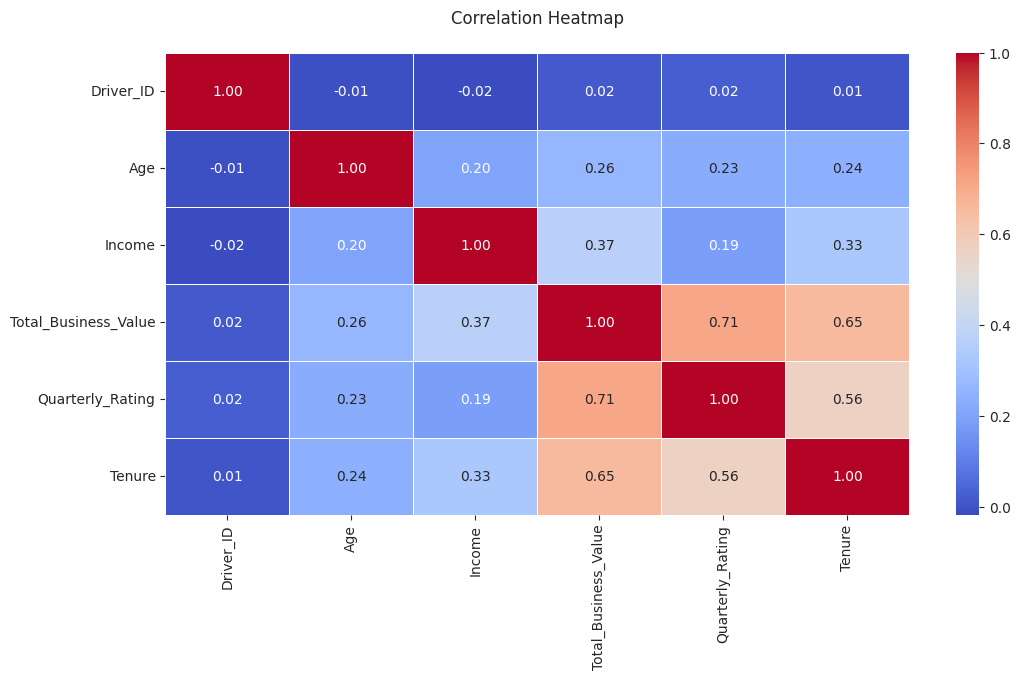

In [ ]:
# Plotting the heatmap for the Correlation matrix.
# Selecting only numerical columns for correlation
corr_matrix = df.select_dtypes(include=['number']).corr()

# Setting up the figure
plt.figure(figsize=(12, 6))

# Creating the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Correlation Heatmap\n")

# Show plot
plt.show()

Income demonstrates a strong positive correlation with Grade (0.74) and Joining Designation (0.48), indicating that higher grades and initial designations are associated with increased earnings.

Total Business Value shows a notable positive correlation with Quarterly Rating (0.71) and Grade (0.38), suggesting that better ratings and higher grades may contribute to improved business performance.

The Target variable exhibits weak or negative correlations with most features, including Grade (-0.23) and Quarterly Rating (-0.37), indicating a more complex relationship with these factors.

###**Categorical Columns' Analysis**

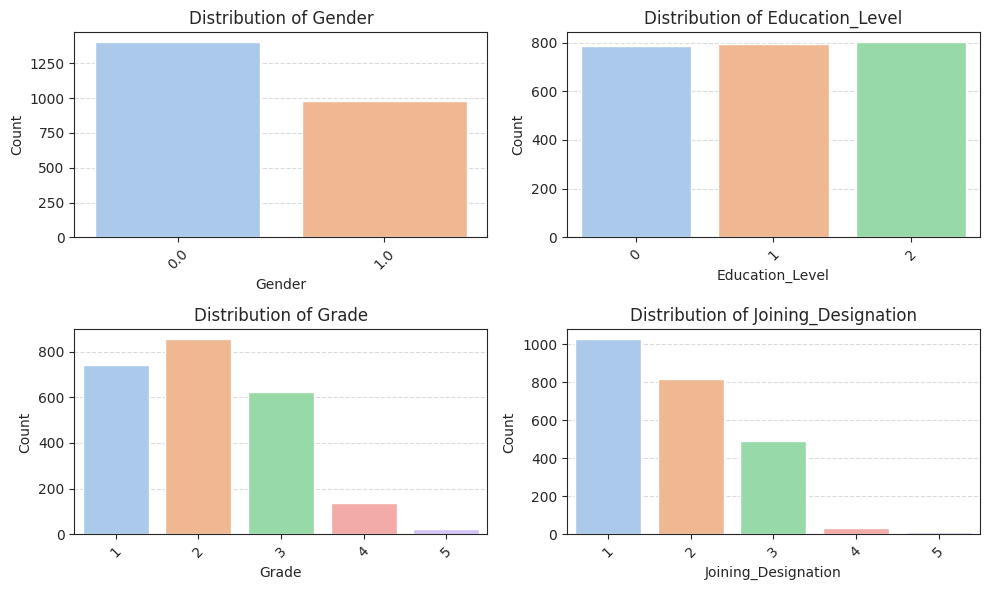

In [ ]:
column_to_plot = [ 'Gender', 'Education_Level', 'Grade', 'Joining_Designation']

# Setting up the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2 rows, 2 columns

# Flattening axes for easier iteration
axes = axes.flatten()


# Plotting each categorical feature as a bar plot
for i, col in enumerate(column_to_plot):
    sns.countplot(data=df, x=col, palette = 'pastel', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Rotating x-axis labels for readability
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)


# Adjust layout
plt.tight_layout()
plt.show()


**Observations**
* The proportion of males is significantly higher compared to females, indicating a gender imbalance in the population or workforce.
* There is no significant dominance of one education level over the others in the dataset.
* Higher grades (Grade 4 and 5) are less frequent, suggesting they may represent more senior or specialized roles.
* Most employees joined at Designation 1, followed by Designation 2 and Designation 3.Very few employees joined at higher designations (4 and 5), indicating that higher designations are less common for new joiners.

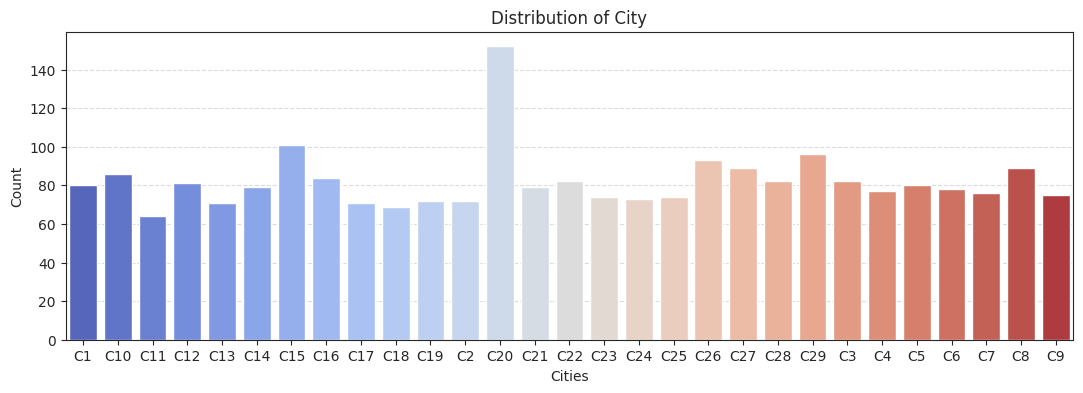

In [ ]:
plt.figure(figsize=(13, 4))
sns.countplot(data=df, x='City', palette= 'coolwarm')
plt.title('Distribution of City')
plt.xlabel('Cities')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Inferences from the Count of Drivers by City:**

City C20 has the highest number of drivers, significantly outpacing other cities.

The distribution of drivers across cities is uneven, with a few cities (like C15, C29) having relatively higher counts compared to others.in specific areas.

# **Bivariate Analysis**

###**Relationship between Age and Income.**

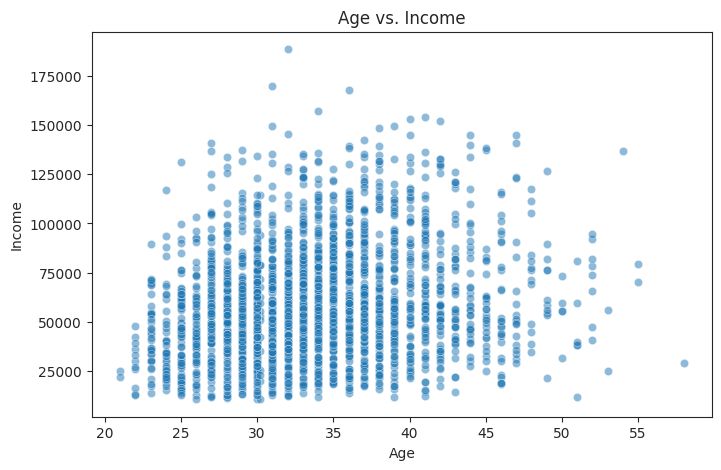

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Age'], y=df['Income'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Age vs. Income')
plt.show()

**Observations:**
* **Initial Growth in Income:** Younger drivers (ages 20–35) typically earn less, while income tends to rise for those in their mid-30s to early 40s.

* **Plateau or Decline After 40:** Beyond the age of 40–45, income levels off or slightly decreases, suggesting that age does not always correlate with higher earnings.

* **High Variability:** Income varies widely across all age groups, as reflected in the spread of data points.

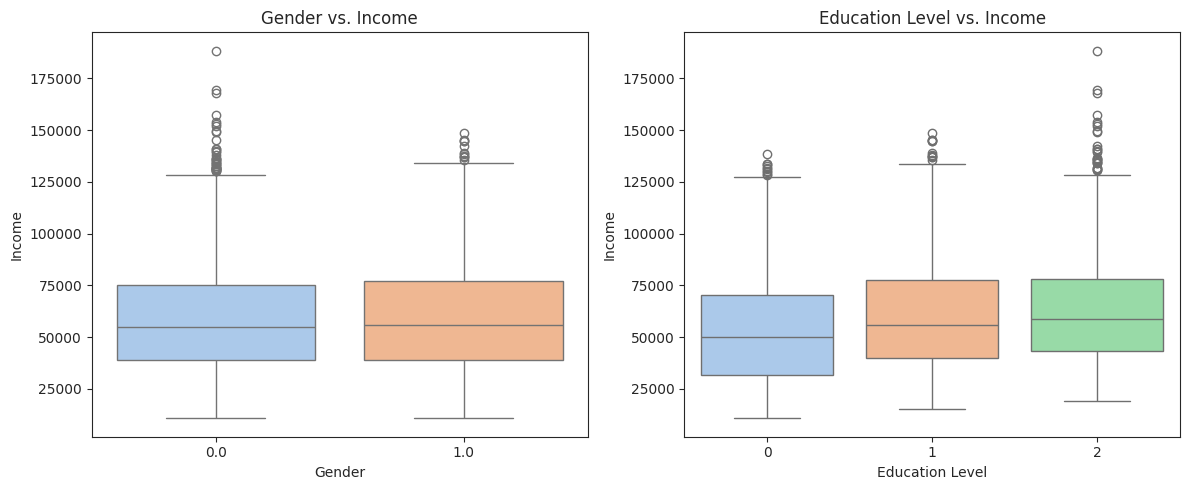

In [ ]:
#Subplots of Gender and education vs Income

# Setting figure size
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gender vs Income
sns.boxplot(x=df['Gender'], y=df['Income'], ax=axes[0], palette = 'pastel')
axes[0].set_title('Gender vs. Income')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Income')

# Education Level vs Income
sns.boxplot(x=df['Education_Level'], y=df['Income'], ax=axes[1], palette = 'pastel')
axes[1].set_title('Education Level vs. Income')
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel('Income')

# Adjusting layout
plt.tight_layout()
plt.show()

**Observations:**

* Income has nothing to do with Gender clearly.

* There is a slight pattern which shows higher the education level, a little higher is the Income

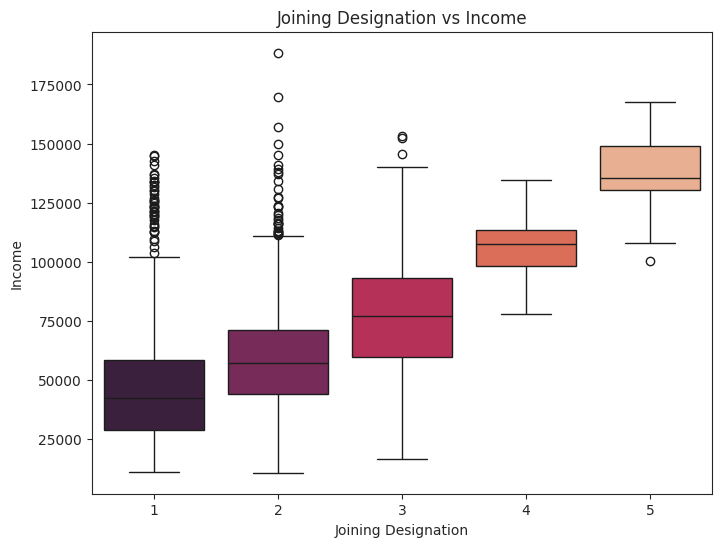

In [ ]:
#Joining Designation vs Income
plt.figure(figsize=(8, 6))

sns.boxplot(data=df,
            x='Joining_Designation',
            y='Income',
            palette='rocket')

plt.title('Joining Designation vs Income')
plt.xlabel('Joining Designation')
plt.ylabel('Income')
plt.show()

**Inferences from the Joining Designation vs. Income Distribution:**

* Positive Relationship: Higher joining designations are associated with higher median incomes, indicating a direct link between designation and earnings.

* Reduced Variability: Income variability decreases at higher designations, with fewer outliers, suggesting greater stability in earnings at senior levels.

### **Finding Factors Influencing Attrition**

To understand why drivers are leaving, it should be analyzed what factors might influence attrition (target variable = 1).

###**Income vs. Attrition**


Checking if less income is linked to higher attrition.

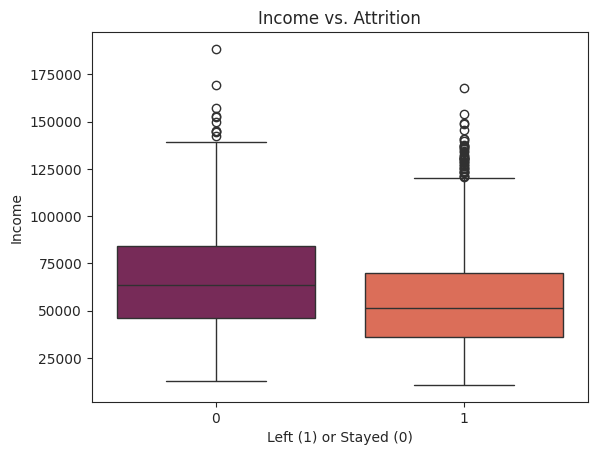

In [ ]:
sns.boxplot(x=df['Target'], y=df['Income'], palette = 'rocket')
plt.title('Income vs. Attrition')
plt.xlabel('Left (1) or Stayed (0)')
plt.ylabel('Income')
plt.show()

**Inferences**

* Drivers who left tend to have slightly lower median incomes compared to those who have stayed in the company

* There is a wider range of income for both groups, but the overall distribution for Target = 1 is skewed toward lower incomes.

###**Gender vs Attrition**

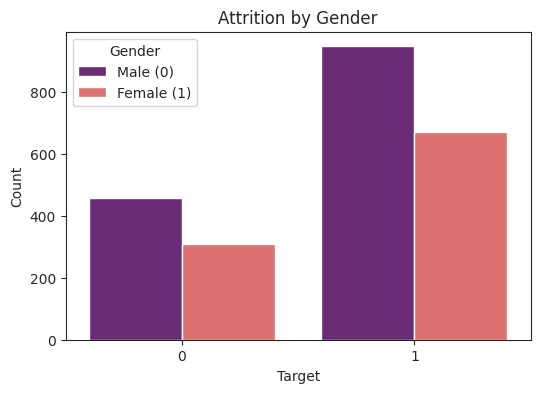

In [ ]:
plt.figure(figsize=(6, 4))

sns.countplot(data=df,x='Target',hue='Gender',palette='magma')

plt.title('Attrition by Gender')
plt.xlabel('Target')
plt.ylabel('Count')

plt.legend(labels=['Male (0)', 'Female (1)'],
           title='Gender')
plt.show()

The number of males who have left the company is higher than females, but the trend is consistent across genders.

### **Quarterly rating vs Attrition**

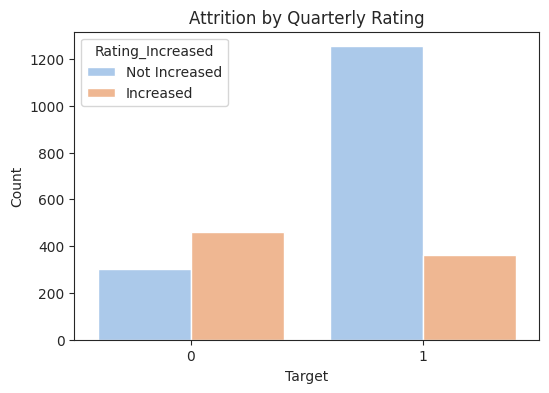

In [ ]:
plt.figure(figsize=(6, 4))

sns.countplot(data=df,x='Target',hue='Quarterly_Rating_Increased',palette='pastel')

plt.title('Attrition by Quarterly Rating')
plt.xlabel('Target')
plt.ylabel('Count')

plt.legend(labels=['Not Increased', 'Increased'],
           title='Rating_Increased')
plt.show()

* Drivers who did not have a quarterly rating increase are more likely to leave the company, as seen from the high count.

* Drivers who experienced a quarterly rating increase are more likely to still be working, suggesting a positive relationship between rating increases and retention.

###**Income_Increased vs Attrition**

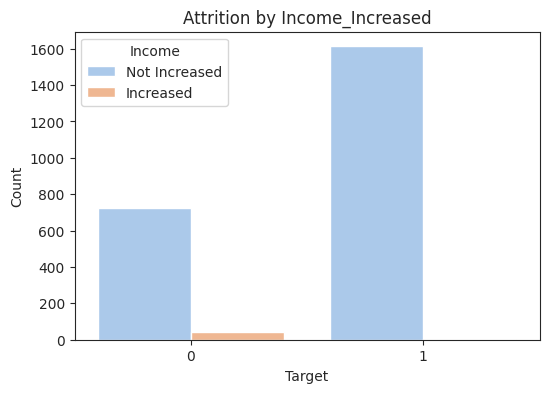

In [ ]:
plt.figure(figsize=(6, 4))

sns.countplot(data=df,x='Target',hue='Income_Increased',palette='pastel')

plt.title('Attrition by Income_Increased')
plt.xlabel('Target')
plt.ylabel('Count')

plt.legend(labels=['Not Increased', 'Increased'],
           title='Income')
plt.show()

Drivers whose income did not increase are far more likely to leave the company compared to staying.

### **Income vs Total Buisness Value**

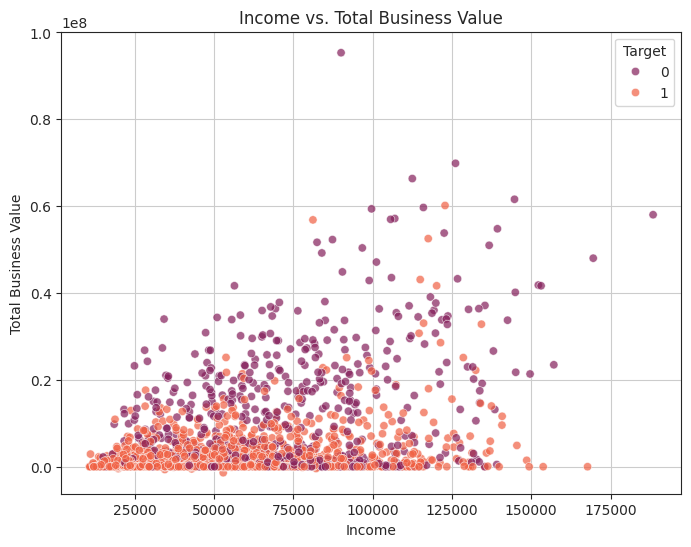

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Income', y='Total_Business_Value', hue='Target', palette='rocket', alpha=0.7)
plt.title('Income vs. Total Business Value')
plt.xlabel('Income')
plt.ylabel('Total Business Value')
plt.grid(True)
plt.show()

**Inferences from the Total Business Value vs. Income Distribution:**  

- **Weak Positive Correlation:** There is a slight upward trend in income as Total Business Value rises, though the relationship remains weak and dispersed.  

- **Concentration at Lower Levels:** The majority of data points are grouped at lower levels of Total Business Value and Income, with a few outliers observed at higher values.  

- **Income Variability:** Income exhibits considerable variation at lower levels of Total Business Value, indicating that other factors likely play a role in influencing earnings.

# **Encoding**

In [ ]:
# Drop unnecessary columns
# Driver_ID is just the ID of the Driver => does not have predictive power.

df.drop(columns=['Driver_ID'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Age                         2381 non-null   float64 
 1   Gender                      2381 non-null   category
 2   City                        2381 non-null   category
 3   Education_Level             2381 non-null   category
 4   Income                      2381 non-null   float64 
 5   Joining_Designation         2381 non-null   category
 6   Grade                       2381 non-null   category
 7   Total_Business_Value        2381 non-null   int64   
 8   Quarterly_Rating            2381 non-null   float64 
 9   Quarterly_Rating_Increased  2381 non-null   category
 10  Target                      2381 non-null   category
 11  Income_Increased            2381 non-null   category
 12  Tenure                      2381 non-null   float64 
dtypes: category(8), fl

In [ ]:
# ONE HOT ENCODING FOR 'CITY' column.

# Step 1: Perform One Hot Encoding only for the 'City' column
city_encoded = pd.get_dummies(df['City'], prefix='City', drop_first=True).astype(int)

# Step 2: Drop the original 'City' column from the dataframe
data_without_city = df.drop(columns=['City'])

# Step 3: Concatenate the one-hot encoded 'City' columns back to the dataframe
df = pd.concat([data_without_city, city_encoded], axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Binary encoding for Gender (0: Male, 1: Female)
df["Gender"] = df["Gender"].map({0: 0, 1: 1})

# Label Encoding for ordinal categorical columns
label_enc_cols = ["Education_Level", "Joining_Designation", "Grade", "Quarterly_Rating_Increased", "Income_Increased"]

for col in label_enc_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# **Standard Scaler**

In [ ]:
from sklearn.preprocessing import StandardScaler

# List of numerical columns to scale
numerical_cols = ["Age", "Income", "Total_Business_Value", "Tenure"]

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [ ]:
df.head()

,Age,Gender,Education_Level,Income,Joining_Designation,Grade,Total_Business_Value,Quarterly_Rating,Quarterly_Rating_Increased,Target,Income_Increased,Tenure,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,City_C18,City_C19,City_C2,City_C20,City_C21,City_C22,City_C23,City_C24,City_C25,City_C26,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,-0.970547,0,2,-0.065228,0,0,-0.314641,2.0,0,1,0,-0.622907,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.463495,0,2,0.275112,1,1,-0.502646,1.0,0,0,0,0.767761,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.564713,0,2,0.225169,1,1,-0.464290,1.0,0,1,0,-0.647198,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.801530,0,0,-0.454699,0,0,-0.489456,1.0,0,1,0,-1.001444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.463495,1,1,0.689077,2,2,-0.364019,1.6,1,0,0,0.717154,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Handling Class Imbalance**

### **SMOTE**

In [ ]:
# Creating a copy of the Dataframe specifically for the RandomForestClassifier
df_rfc = df.copy()

X = df_rfc.drop(columns=["Target"])
y = df_rfc["Target"]

# Split the data into training and testing sets
# because SMOTE is applied only on the Training Data
# and not on the Testing Data.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=10)

# Handle missing values with SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Use 'mean', 'median', or 'most_frequent' as needed
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply SMOTE to the training set
smote = SMOTE(random_state=10)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
from collections import Counter
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution before SMOTE: Counter({1: 1298, 0: 606})
Class distribution after SMOTE: Counter({1: 1298, 0: 1298})


## **Bagging Algorithm- Random Forest Classifier**

### **Best Parameters**(Hyperparameter Tuning)

In [ ]:
# Define the Random Forest model

rf = RandomForestClassifier(random_state=10)
rf.fit(X_train_resampled, y_train_resampled)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of iterations
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=10
)

random_search.fit(X_train_resampled, y_train_resampled)

# Best parameters from RandomizedSearchCV
print("\nBest parameters found: ", random_search.best_params_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


### **Training the Model with Best Parameter**

In [ ]:
best_rf = random_search.best_estimator_
best_rf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred = best_rf.predict(X_train_resampled)
y_test_pred = best_rf.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy:  {test_accuracy:.2f}")

# Precision, Recall, and F1 Score (assuming binary classification)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")




Training Accuracy: 1.00
Testing Accuracy:  0.97

Precision: 1.00
Recall:    0.95
F1 Score:  0.98


**Confusion Matrix**

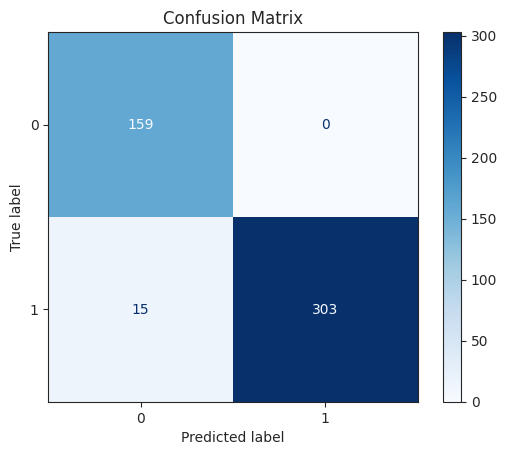

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### **ROC Curve**

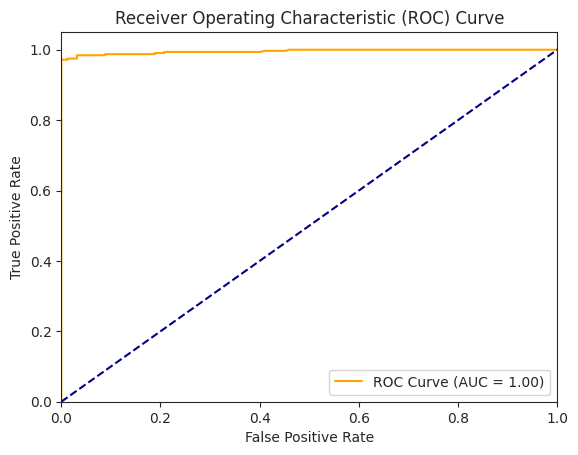

In [ ]:
y_proba = best_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr,
         color='orange',
         label=f"ROC Curve (AUC = {roc_auc:.2f})"
         )

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## **Boosting Algoruthm- Gradient Boosting Classifier**

In [ ]:
# Creating a copy of the Dataframe specifically for the GradientBoostedClassifier

df_gbc = df.copy()
X = df_gbc.drop(columns=["Target"])
y = df_gbc["Target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=10)

# Handle missing values with SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Use 'mean', 'median', or 'most_frequent' as needed
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply SMOTE to the training set
smote = SMOTE(random_state=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))



Class distribution before SMOTE: Counter({1: 1298, 0: 606})
Class distribution after SMOTE: Counter({1: 1298, 0: 1298})


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters found:  {'learning_rate': 0.22437273501930718, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 208, 'subsample': 0.9130411238745376}

Training Accuracy: 1.00
Testing Accuracy:  0.98

Precision: 1.00
Recall:    0.97
F1 Score:  0.99


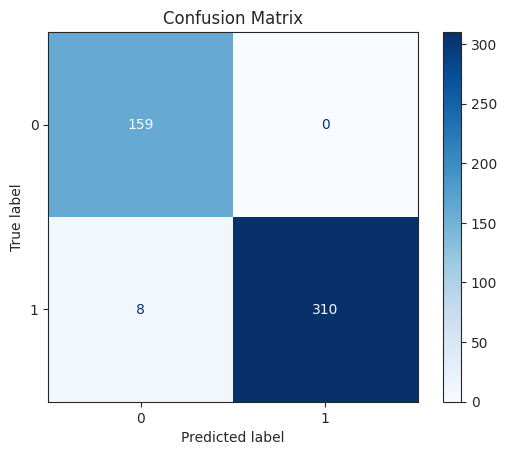

In [ ]:
# Define the Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=10)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),  # Number of boosting stages to be run
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinkage used to prevent overfitting
    'max_depth': randint(3, 15),  # Maximum depth of the individual estimators
    'min_samples_split': randint(2, 10),  # Minimum samples required to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum samples required at a leaf node
    'subsample': uniform(0.5, 0.5),  # Fraction of samples used for fitting the individual trees
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider for each split
}

random_search = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_dist,
    n_iter=10,  # Number of different combinations to try
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=10
)

random_search.fit(X_train_resampled, y_train_resampled)

# Best parameters from RandomizedSearchCV
print("\nBest parameters found: ", random_search.best_params_)

# Train the best model
best_gbc = random_search.best_estimator_
best_gbc.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred = best_gbc.predict(X_train_resampled)
y_test_pred = best_gbc.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy:  {test_accuracy:.2f}")

# Precision, Recall, and F1 Score (assuming binary classification)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

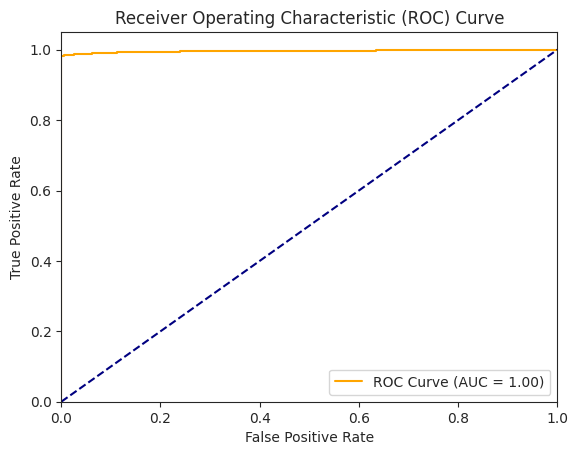

In [ ]:
# ROC Curve

y_proba = best_gbc.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, color='orange', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Creating a copy of the Dataframe specifically for the XGBoost

df_xgb = df.copy()
X = df_xgb.drop(columns=["Target"])
y = df_xgb["Target"]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=10)

# Handle missing values with SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Use 'mean', 'median', or 'most_frequent' as needed
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply SMOTE to the training set
smote = SMOTE(random_state=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution before SMOTE: Counter({1: 1298, 0: 606})
Class distribution after SMOTE: Counter({1: 1298, 0: 1298})



Training Accuracy: 1.00
Testing Accuracy:  0.99

Precision: 1.00
Recall:    0.98
F1 Score:  0.99


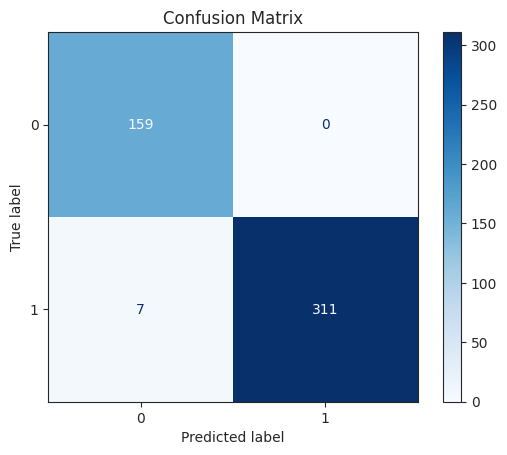

In [ ]:
# Initialize and train the XGBoost Classifier
xgb_model = xgb(use_label_encoder=False, eval_metric='logloss', random_state=10)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred = xgb_model.predict(X_train_resampled)
y_test_pred = xgb_model.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy:  {test_accuracy:.2f}")

# Precision, Recall, and F1 Score (assuming binary classification)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


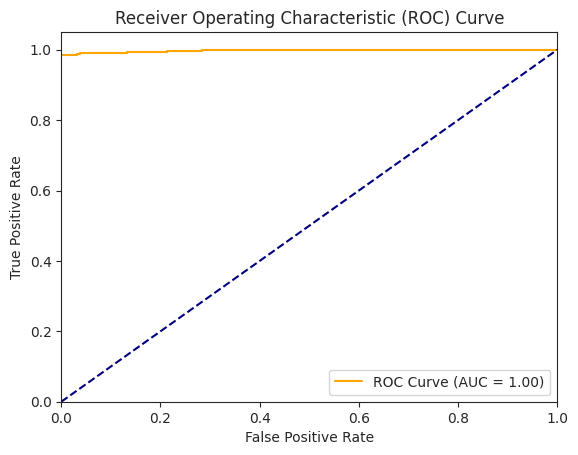

In [ ]:
# ROC Curve

y_proba = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, color='orange', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## **LightGBM Classifier**

In [ ]:
# Creating a copy of the Dataframe specifically for the RandomForestClassifier

df_lgb = df.copy()
X = df_lgb.drop(columns=["Target"])
y = df_lgb["Target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=10)

# Handle missing values with SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Use 'mean', 'median', or 'most_frequent' as needed
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply SMOTE to the training set
smote = SMOTE(random_state=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))



Class distribution before SMOTE: Counter({1: 1298, 0: 606})
Class distribution after SMOTE: Counter({1: 1298, 0: 1298})


[LightGBM] [Info] Number of positive: 1298, number of negative: 1298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 2596, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Training Accuracy: 1.00
Testing Accuracy:  0.98

Precision: 1.00
Recall:    0.97
F1 Score:  0.99


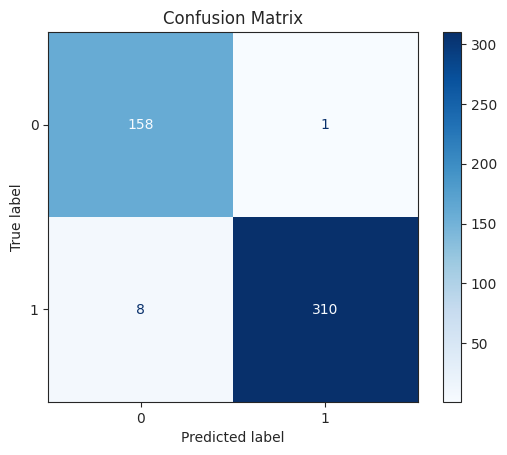

In [ ]:
# Initialize and train the LightGBM Classifier
lgb_model = lgbm(random_state=10)
lgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred = lgb_model.predict(X_train_resampled)
y_test_pred = lgb_model.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy:  {test_accuracy:.2f}")

# Precision, Recall, and F1 Score (assuming binary classification)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

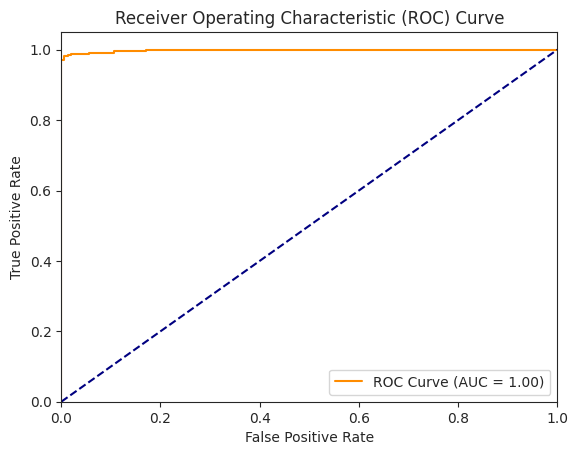

In [ ]:
# ROC Curve

y_proba = lgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

#**Insights**

* **Demographics & Workforce Overview:**
 * The workforce consists of 58% male and 42% female employees.

 * Out of 2,381 drivers, 1,616 have exited the company, highlighting a significant turnover issue.
* **Key Drivers of Employee Attrition:**
 * Employees with improving quarterly ratings tend to stay longer.

 * Lack of salary increments strongly correlates with attrition, as 97.3% of those who didn't receive a raise are more likely to leave.
* **Strategies for Retention:**
 * Introduce incentive programs, such as overtime pay and additional benefits, to lower turnover rates.

* **Performance & Career Progression:**
 * Only 2.6% of employees received a salary increase, indicating limited growth opportunities.
 * A large proportion (1,744 employees) had a quarterly rating of 1, and for 2,076 employees, ratings have remained unchanged, signaling a lack of performance-based career advancement.
* **Designation & Reporting Trends:**
 * 43% of employees began at the lowest level (Level 1), followed by 34% at Level 2 and 20% at Level 3.
 * Currently, Level 2 holds the largest share (35%), followed by Level 1 (31%) and Level 3 (26%), while higher levels remain under 5%.
 * Over time, both workforce size and reporting frequency have increased, with City C20 having the highest employee concentration.
* **Salary & Business Value Analysis:**
 * Income generally increases with age but declines after 45-50 years.
 * Total Business Value follows a similar pattern, rising with age before tapering off around 45 years.
 * Higher designations do not necessarily equate to better pay, as only 4% of employees hold senior roles.
 * Employees in higher grades tend to earn more on average.
 * The income gap across different education levels is relatively small, ranging between 3-5%.
 * Higher grades correlate with better joining designations.
 * Total Business Value and income tend to rise as reporting frequency increases.


# **Recommendations**
* **Employee Retention Strategies:**
 * Introduce incentive programs such as overtime pay and additional benefits to improve job satisfaction and reduce attrition.
 * Implement a customer feedback reward system to encourage ratings and reviews, fostering a performance-driven culture.
 * Address salary stagnation by offering bonuses and performance-based perks to enhance employee morale.
 * Identify at-risk employees early by monitoring key indicators like quarterly ratings and Total Business Value.
 * Establish mentorship and career growth programs to support professional development and long-term retention.
 * Conduct regular performance evaluations and maintain transparent communication regarding salary adjustments and promotion opportunities.
* **Performance Enhancement Recommendations:**
 * Set clear performance targets and provide specialized training programs to improve efficiency.
 * Introduce recognition and incentive programs for employees demonstrating consistent improvement.
 * Ensure regular feedback sessions to guide employees toward continuous professional growth.
* **Designation & Career Progression Management:**
 * Develop structured career progression pathways to motivate employees toward higher designations.
 * Implement leadership training programs to nurture employees at lower levels for future managerial roles.
 * Regularly evaluate job roles to ensure alignment with employee skills and career aspirations.
* **Salary & Business Value Optimization:**
 * Reassess salary structures to offer competitive increments and retain top talent.
 * Introduce skill-based incentives to drive higher business value contributions.
 * Provide financial literacy workshops to help employees make informed financial decisions and maximize earnings.



**Conclusion:**
To reduce attrition and improve retention, the company must prioritize salary adjustments, performance-based rewards, and customer engagement initiatives. By closely monitoring key performance indicators, fostering a growth-oriented work environment, and offering structured career advancement opportunities, employee satisfaction and business value can be significantly enhanced.